<a target="_blank" href="https://colab.research.google.com/github/meyer-lab-cshl/BATMAN/blob/main/run_batman/pyBATMAN_Tutorial.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>&emsp;[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/meyer-lab-cshl/BATMAN/HEAD?urlpath=https%3A%2F%2Fgithub.com%2Fmeyer-lab-cshl%2FBATMAN%2Fblob%2Fmain%2Frun_batman%2FpyBATMAN_Tutorial.ipynb)&emsp;&emsp;[![PyPI version](https://badge.fury.io/py/pybatman.svg)](https://pypi.org/project/pybatman/)&emsp;[![License](https://img.shields.io/badge/License-BSD_3--Clause-blue.svg)](https://github.com/meyer-lab-cshl/BATMAN/blob/main/LICENSE)


**BATMAN: Bayesian inference of Activation of TCR by Mutant Antigens🦇**


---
<p align="center" width="100%">
<img width="35%" align="center" src="https://github.com/meyer-lab-cshl/BATMAN/blob/main/BATMAN_schematic_github.jpg?raw=1" alt="BATMAN schematic diagram showing that it integrates mutational scan datasets across many TCRs to build a hierarchical Bayesian inference model. BATMAN infers hyperparameters from the training database and uses them to generate prior distributions for cross-TCR AA distance and TCR-specific positional weights, which are multiplied and used as a predictor of TCR activation by a given mutant."> </p>

# Introduction
A single T Cell Receptor (TCR) can recognize a diverse variety of peptides, an essential property known as TCR cross-reactivity. Predicting which peptides a TCR cross-reacts to is critical for numerous applications, including predicting viral escape, cancer neoantigen immunogenicity, autoimmunity, and off-target toxicity of T-cell-based therapies. But predicting TCR activation is challenging due to the lack of both unbiased benchmarking datasets and computational methods that are sensitive to small mutations to an epitope. To address these challenges, we developed an interpretable Bayesian model, called BATMAN, that can predict the set of epitopes that activate a TCR. When validated on our database, BATMAN outperforms existing methods by 20% and reveals important biochemical predictors of TCR-peptide interactions.

BATMAN predicts TCR activation by mutant peptides based on their distances to the TCR's index peptide. The peptide-to-index distance is a product of a learned positional weight profile vector, corresponding to effects of mutated residues at different positions in the sequence, and a learned AA substitution distance from the index peptide amino acid to the mutant amino acid.

BATMAN can be trained in two modes: (1) within-TCR, where the train and test peptides are associated with the same TCR, and BATMAN-inferred positional weight profiles are TCR-specific, and (2) leave-one-TCR-out, where peptides are tested for activation of a TCR left out of the training data, and BATMAN-inferred positional weight profile is common across all TCRs.

For more information, refer to our preprint!

🦇🦇🦇🦇🦇🦇🦇🦇🦇🦇🦇🦇🦇🦇🦇🦇🦇🦇🦇🦇🦇🦇🦇🦇🦇🦇🦇🦇🦇🦇🦇🦇🦇🦇🦇🦇🦇🦇🦇🦇

In this notebook we will work with the Python implementation of BATMAN, named 'pyBATMAN'. After installing pyBATMAN, we will train and validate it using a sample dataset in both within-TCR and leave-one-TCR-out modes. Finally, we will have a look at the learned positional weight profiles and amino acid substitution distance matrices to check if they make sense.

# Installing pyBATMAN

pyBATMAN requires Python v3.11 to run, which is slightly newer than the version currently used by Colab (v3.10). So we will first install Python v3.11 and set the colab paths to the installed package folder so that we can work with Python v3.11 in Colab.

In [ ]:
# Install python v3.11 to work with pyBATMAN
!sudo apt-get update -y
!sudo apt-get install python3.11 python3.11-dev python3.11-distutils libpython3.11-dev
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.11 2
!sudo update-alternatives --config python3

# install pip
!curl https://bootstrap.pypa.io/get-pip.py -o get-pip.py
!python3 get-pip.py --force-reinstall

# Add packages to system path
import sys
sys.path.append("/usr/local/lib/python3.11/dist-packages")

Then we will pip install pyBATMAN in the usual way.

In [ ]:
# Install pyBATMAN
!pip install pybatman

For future usage, we will import two key functions from pyBATMAN (we will discuss later what they do), and also import some usual Python packages for downstream analysis of BATMAN outputs.

In [14]:
# Load two main functions from pyBATMAN
from pybatman.functions import train, peptide2index

# Import packages for downstream analysis of BATMAN outputs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
import seaborn as sns

# Uploading sample TCR-pMHC dataset

Now we will need to upload a sample TCR-pMHC dataset to train and validate pyBATMAN. We will load the 'test_input.csv' file from the [BATMAN project GitHub link](https://github.com/meyer-lab-cshl/BATMAN/blob/main/run_batman/test_input.csv). At the end of the tutorial, hopefully you can upload your own csv data file and try this tutorial.

Voila! We are all set to fly now🦇!

To familiarize with the dataset, let's print its top 5 entries.

In [15]:
# Read full dataset from GitHub url
url = 'https://github.com/meyer-lab-cshl/BATMAN/blob/main/run_batman/test_input.csv?raw=true' #Note the part '?raw=true'
full_peptide_data = pd.read_csv(url)

# Sneak-peak into the data
print(full_peptide_data.head(5))

    tcr      index    peptide  activation
0  TCR1  NLVPMVATV  NLVPMVATV           2
1  TCR1  NLVPMVATV  ALVPMVATV           2
2  TCR1  NLVPMVATV  CLVPMVATV           2
3  TCR1  NLVPMVATV  DLVPMVATV           1
4  TCR1  NLVPMVATV  ELVPMVATV           2


The input TCR-pMHC dataset must be a csv file containing 4 columns with the following names and structure: "tcr" and "peptide" columns referring to the name of the TCR and sequence of the peptide respectively in a TCR-pMHC pair. The "index" column refers to the index peptide of the TCR. Finally, the "activation" column refers to ordered categorical activation level of the TCR, when it interacts with the indicated peptide: 0 means no activation, 1 means weak activation, and 2 means strong activation. Note that whereas we standardized BATMAN to work with 2 or 3 TCR activation levels, you can have an arbitrary number of activation levels in your data, but they must start from 0 (non or weakest activation) and be consecutive integers denoting increasing activation without any missing level.

 Our dataset has 7 TCRs, with names "TCR1", "TCR2",...,"TCR7", which recognize 3 different index peptides together. You can display them below.

In [16]:
print(full_peptide_data[['tcr','index']].drop_duplicates())

       tcr      index
0     TCR1  NLVPMVATV
172   TCR2  NLVPMVATV
344   TCR3  NLVPMVATV
516   TCR4  IMDQVPFSV
688   TCR5  IMDQVPFSV
860   TCR6  IMDQVPFSV
1032  TCR7  GRLKALCQR


The data is sourced from the paper: "Neoantigen quality predicts immunoediting in survivors of pancreatic cancer", [Nature, volume 606, pages 389-395 (2022)](https://www.nature.com/articles/s41586-022-04735-9) figures 3d and 3f.

# Within-TCR classification by BATMAN

We will split the full dataset into train (90%) and test (10%) subset. Both will contain data from all 7 TCRs present in the dataset. We will combine training data across all these TCRs to learn common features of TCR-pMHC interactions (e.g., the amino acid substitution distance matrix), but will infer 7 individual positional weight profiles with BATMAN.

In [17]:
# Generate random array of about 90% 1s and 10% 0s following binomial distribution
np.random.seed(0) #Random seed for reproducible results
train_test_index = np.random.binomial(n=1, p=0.9,
                                      size=len(full_peptide_data))
# # Split data into train (90%) and test (10%) and save train and test data
train_data = full_peptide_data[train_test_index==1]
train_data.to_csv('train.csv')

test_data = full_peptide_data[train_test_index==0]
test_data.to_csv('test.csv')

One final ingredient before we train BATMAN. Even though BATMAN learns custom AA substitution matrix from data, we need to specify a good prior for that, so that BATMAN does not overfit the data.

Conveniently, pyBATMAN comes with dozens of pre-saved conventional amino acid substitution distance matrices (e.g., hamming, blosum62, blosum100, pam30, pam100, dayhoff, gonnet etc), and we can use one of them. Alternatively, we can also upload custom amino acid substitution matrix as a datafile and pass it to pyBATMAN as a 20-by-20 Pandas dataframe with amino acid letters as row and column names.

In [18]:
# Load a pre-saved amino acid matrix prior by its name
AA_matrix_name = 'blosum100' #(you can change it to others, e.g., hamming, blosum62, pam30 etc)
AA_matrix_prior = pd.read_csv(''.join(['/usr/local/lib/python3.11/dist-packages/',
                                       'pybatman/data/AA_matrices/',
                                       AA_matrix_name,'.csv']),index_col=0)

Finally, we are all set to train pyBATMAN to infer TCR-specific positional weight profiles and an amino acid distance matrix.

BATMAN performs approximate Bayesian inference with automatic differentiation variational inference (ADVI) method to learn the weight profiles and amino acid matrices. You can optionally specify the number of steps in this method (default=20,000) and check that the loss function converges. pyBATMAN runs in 3 modes: (1) "full", which we will use below and is the most general one working without any constraint, (2) "symm", where we constrain the inferred amino acid matrix to be symmetric, and (3) "weight_only" where we only infer positional weights and directly use the amino acid distance matrix supplied without inferring amy amino acid matrix.

Wait for a few minutes as pyBATMAN sets up the Bayesian model, after which you will be able to see the progress bar as pyBATMAN is trained. Make sure to check that the loss function stabilizes, otherwise, increase the number of steps. Your patience will be rewarded!

In [22]:
#Train pyBATMAN and infer full asymmetric AA matrix and TCR-specific weights
inferred_weights, inferred_AA_matrix = train('train.csv','full',
                                             AA_matrix_prior,
                                             steps=80000, seed=10)

Shape validation failed: input_shape: (1, 50000), minimum_shape: (chains=2, draws=4)


Okay, we made it! We trained BATMAN on our data, now it is time to apply the trained model to test data and visualize and interpret results.

But first, let's have a look at the inferred TCR-specific weight profiles.

In [23]:
# Print TCR-specific positional weight profiles (just to see them)
print(inferred_weights)

          0      1      2      3      4      5      6      7      8
TCR1  0.063  0.112  0.377  0.086  0.851  0.598  0.836  0.429  0.391
TCR2  0.060  0.046  0.140  0.700  0.676  0.608  0.734  0.855  0.330
TCR3  0.701  0.171  0.252  0.294  0.823  0.373  0.138  0.335  0.206
TCR4  0.728  0.281  0.738  0.803  0.590  0.546  0.391  0.047  0.259
TCR5  0.041  0.067  0.271  0.719  0.618  0.740  0.669  0.130  0.188
TCR6  0.653  0.419  0.593  0.467  0.181  0.777  0.260  0.040  0.252
TCR7  0.036  0.517  0.192  0.798  0.725  0.463  0.757  0.085  0.045


So pyBATMAN indeed inferred positional weights for individual TCRs, even if it was trained jointly on them. Note how the weights peak near the middle positions of the peptide chain, where TCR-binding motifs are often located.

Now let's have a look at the what amino acid substituion matrix BATMAN inferred. For better visualization, we order the amino acids according to their hydrophobicity and plot three matrices: the full inferred amino acid substitution matrix, as well as its symmetric and anti-symmetric part.

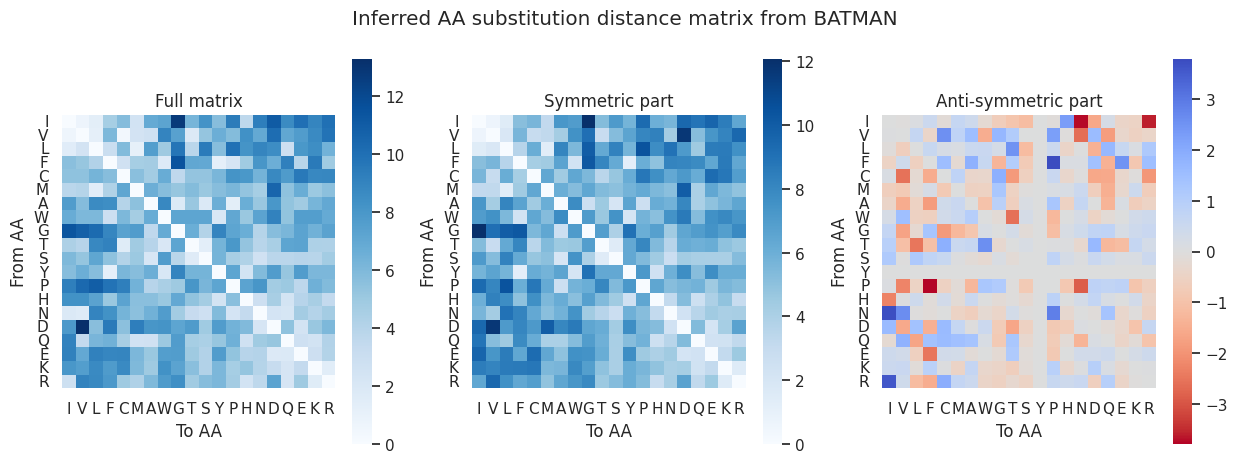

In [24]:
#visualize inferred matrices (symm and antisymm part)
# Order AAs according to decreasing hydrophobicity
AA_list = ['I','V','L','F','C','M','A','W','G','T','S','Y',
           'P','H','N','D','Q','E','K','R']

# Load inferred amino acid distance matrix
AA_distance_matrix = inferred_AA_matrix.loc[AA_list,AA_list]

# plot heatmaps
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15, 5))
plt.suptitle('Inferred AA substitution distance matrix from BATMAN')

plt.subplot(1, 3, 1)
sns.heatmap(AA_distance_matrix,cmap="Blues",
            yticklabels=AA_list,
            xticklabels=AA_list,
            square=1)
plt.yticks(rotation=0);
plt.xlabel('To AA');
plt.ylabel('From AA');
plt.title('Full matrix');

plt.subplot(1, 3, 2)
sns.heatmap((AA_distance_matrix+np.transpose(AA_distance_matrix))/2,
            cmap="Blues",
            yticklabels=AA_list,
            xticklabels=AA_list,
            square=1)
plt.yticks(rotation=0);
plt.xlabel('To AA');
plt.ylabel('From AA');
plt.title('Symmetric part');

plt.subplot(1, 3, 3)
sns.heatmap((-AA_distance_matrix+np.transpose(AA_distance_matrix))/2,
            cmap="coolwarm_r",
            yticklabels=AA_list,
            xticklabels=AA_list,
            square=1)
plt.yticks(rotation=0);
plt.xlabel('To AA');
plt.ylabel('From AA');
plt.title('Anti-symmetric part');

The symmetric part shows that large distances are associated with hydrophobic to hydrophilic substitutions and vice versa. The anti-symmetric part shows that, e.g., if you substitute out isoleucine (I), you lose TCR activation, and you gain activation by bringing in I. So TCRs are seen to favor hydrophobic residues, which was previously known in literature, but BATMAN quantified it using the data.

Finally, judgement day! How good are BATMAN inferred weights and amino matrix in predicting TCR activation by mutants? In order to validate that, we use a scalar quantity, called peptide-to-index distance function, which multiplies the inferred positional weight of the mutation position and the inferred amino acid matrix element corresponding to the mutation to generate a distance between the TCR index peptide and mutant peptide.

We calculate this distance for all mutant peptides corresponding to a chosen TCR (TCR1) in the test data and plot a ROC curve for class 0-(1,2) classification based on the distance.

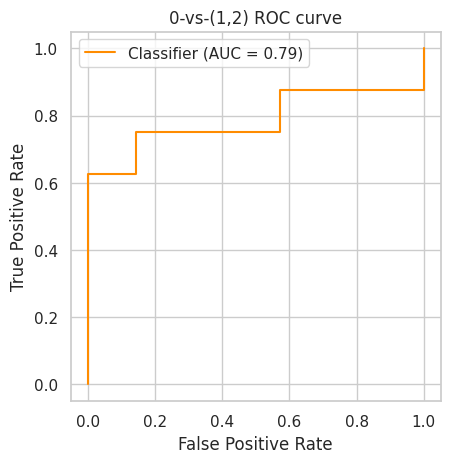

In [25]:
# Generate peptide2index distances for test data from a selected TCR with trained pyBATMAN

# Pick a TCR to test
tcr_name = 'TCR1'

#Read test data
peptide_data = pd.read_csv('test.csv')

# Extract index peptide and mutant peptide list for the particular TCR
index_peptide = peptide_data[peptide_data.tcr==tcr_name]['index'].tolist()

mutant_peptide_list = peptide_data[peptide_data.tcr==
                                   tcr_name]['peptide'].tolist()

# Activation levels of the selected TCR against mutants
activation =  peptide_data[peptide_data.tcr==
                                   tcr_name]['activation'].to_numpy()

# BATMAN-inferred positional weight profile for the selected TCR
weight_profile = inferred_weights.loc[[tcr_name]].to_numpy()

# Generate peptide-to-index distances with pyBATMAN
peptide_distance = peptide2index(index_peptide,
                                 mutant_peptide_list,
                                 inferred_AA_matrix, #Use inferred matrix
                                 weight_profile)

#Plot ROC based on peptides-to-index distances for 0 and (1,2) classes
activation[activation==2]=1

RocCurveDisplay.from_predictions(
    activation,
    -peptide_distance, pos_label = 1, #-ve sign since weaker binders are further
    color="darkorange")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("0-vs-(1,2) ROC curve")
plt.legend()
plt.show()

Pretty good! You can now play with pyBATMAN specifications (e.g., training mode, prior matrix, and number of steps) to see if you can improve the performance and see how it varies from one test TCR data to another.

# Leave-one-TCR-out classification by BATMAN

For leave-one-TCR-out training, we split the dataset across TCRs - training dataset has full data from 6 TCRs, and test data has full data from the 7th TCR in the dataset. Again, we will combine training data across all training data TCRs to learn common features of TCR-pMHC interactions (e.g., the amino acid substitution distance matrix), but this time we will infer a single positional weight profile with BATMAN, which we will subsequently use to calculate mutant-to-index distances of the peptides corresponding to the left out test TCR.

A trick so that pyBATMAN does infer a pan-TCR single weight profile: we rename all 6 TCRs in the training dataset by a common name, to force pyBATMAN to think the data comes from a single TCR.

In [35]:
# We split full data into train and test, leaving one TCR out
left_out_TCR = 'TCR7'

# Split and save train and test data
train_data = full_peptide_data[full_peptide_data.tcr!=left_out_TCR].copy()
# The trick to name all TCRs the same so that BATMAN gives a single weight profile
train_data.tcr = 'TCR'
train_data.to_csv('train.csv')

test_data = full_peptide_data[full_peptide_data.tcr==left_out_TCR]
test_data.to_csv('test.csv')

Load an amino acid substitution matrix prior as before.

In [36]:
# (Note that for some reason, pyBATMAN is not able to load AA matrix data, so we load it explicitly)
AA_matrix_name = 'blosum100' #(you can change it to others, e.g., hamming, blosum62, pam30 etc)
AA_matrix_prior = pd.read_csv(''.join(['/usr/local/lib/python3.11/dist-packages/',
                                       'pybatman/data/AA_matrices/',
                                       AA_matrix_name,'.csv']),index_col=0)

Train pyBATMAN as before. Wait for a few minutes as BATMAN sets up the Bayesian model, after which you will be able to see the progress bar.


In [37]:
#Train pyBATMAN and infer full asymmetric AA matrix and TCR-specific weights
inferred_weights, inferred_AA_matrix = train('train.csv','full',
                                             AA_matrix_prior,
                                             steps=80000, seed=20)

Shape validation failed: input_shape: (1, 50000), minimum_shape: (chains=2, draws=4)


Print inferred weight profile and see that there is indeed a single pan-TCR weight profile. This also peaks near the middle of the peptide chain, since this is a common feature across all TCRs in our dataset.

In [38]:
# Print positional weight profile (Check that there is a single one)
print(inferred_weights)

         0      1      2     3      4      5      6     7      8
TCR  0.088  0.048  0.282  0.23  0.458  0.556  0.334  0.09  0.186


Visualize the inferred amino acid substitution matrix like before.

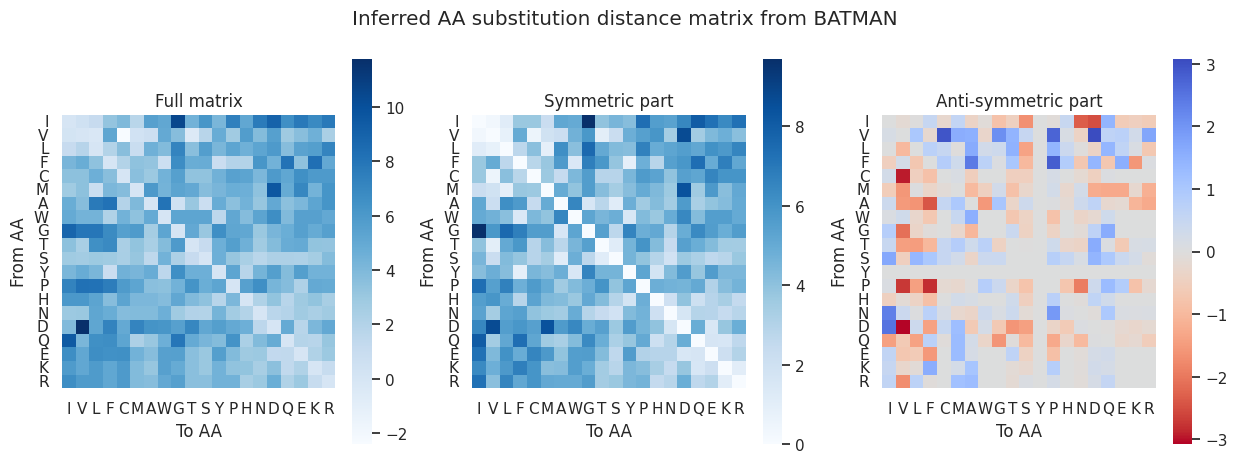

In [39]:
#visualize inferred matrices (symm and antisymm part)
# Order AAs according to decreasing hydrophobicity
AA_list = ['I','V','L','F','C','M','A','W','G','T','S','Y',
           'P','H','N','D','Q','E','K','R']

# Load inferred amino acid distance matrix
AA_distance_matrix = inferred_AA_matrix.loc[AA_list,AA_list]

# plot heatmaps
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15, 5))
plt.suptitle('Inferred AA substitution distance matrix from BATMAN')

plt.subplot(1, 3, 1)
sns.heatmap(AA_distance_matrix,cmap="Blues",
            yticklabels=AA_list,
            xticklabels=AA_list,
            square=1)
plt.yticks(rotation=0);
plt.xlabel('To AA');
plt.ylabel('From AA');
plt.title('Full matrix');

plt.subplot(1, 3, 2)
sns.heatmap((AA_distance_matrix+np.transpose(AA_distance_matrix))/2,
            cmap="Blues",
            yticklabels=AA_list,
            xticklabels=AA_list,
            square=1)
plt.yticks(rotation=0);
plt.xlabel('To AA');
plt.ylabel('From AA');
plt.title('Symmetric part');

plt.subplot(1, 3, 3)
sns.heatmap((-AA_distance_matrix+np.transpose(AA_distance_matrix))/2,
            cmap="coolwarm_r",
            yticklabels=AA_list,
            xticklabels=AA_list,
            square=1)
plt.yticks(rotation=0);
plt.xlabel('To AA');
plt.ylabel('From AA');
plt.title('Anti-symmetric part');

Finally, plot the ROC curved for the left out TCR, based on the mutant-to-index distances of peptides calculated using BATMAN-inferred pan-TCR positional weight profile and amino acid matrix.

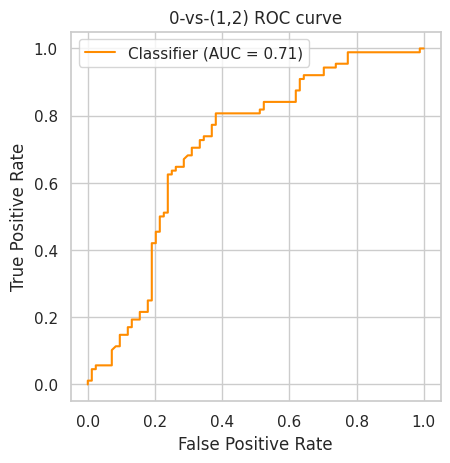

In [40]:
#Generate peptide2index distances for test data from a selected TCR with trained pyBATMAN
#Read data
peptide_data = pd.read_csv('test.csv')

# Extract data for a particular TCR
tcr_name = left_out_TCR

index_peptide = peptide_data[peptide_data.tcr==tcr_name]['index'].tolist()

mutant_peptide_list = peptide_data[peptide_data.tcr==
                                   tcr_name]['peptide'].tolist()

# Activation levels of the selected TCR against mutants
activation =  peptide_data[peptide_data.tcr==
                                   tcr_name]['activation'].to_numpy()

# Inferred pan-TCR positional weight profile
weight_profile = inferred_weights.to_numpy()

# generate peptide-to-index distances with pyBATMAN
peptide_distance = peptide2index(index_peptide,
                                 mutant_peptide_list,
                                 inferred_AA_matrix,
                                 weight_profile)

#plot ROC based on peptides-to-index distances for 0 and (1,2) classes
activation[activation==2]=1

RocCurveDisplay.from_predictions(
    activation,
    -peptide_distance, pos_label = 1, #-ve sign since weaker binders are further
    color="darkorange")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("0-vs-(1,2) ROC curve")
plt.legend()
plt.show()

Pretty good again, given that we only trained on data from 6 TCRs to predict about an unseen TCR specific for an unseen index peptide!

Finally, upload you own TCR dataset as a csv file in the same format as ours to apply pyBATMAN on your data and visualize results.

🦇🦇🦇🦇🦇🦇🦇🦇🦇🦇🦇🦇🦇🦇🦇🦇🦇🦇🦇🦇🦇🦇🦇🦇🦇🦇🦇🦇🦇🦇🦇🦇🦇🦇🦇🦇🦇🦇🦇🦇